# Kepler Problem with Projected ODE Solvers

This notebook demonstrates the `ProjectedOdeSolver` from `invflow.adaptive` - a flexible framework for invariant-preserving numerical integration that works with any SciPy ODE solver.

**Key Features:**
- Generic wrapper for any SciPy ODE solver (RK45, RK23, DOP853, etc.)
- Customizable projection methods for invariant preservation
- Comprehensive performance analysis with timing and conservation metrics
- Clean, modular architecture for research and production use

The Kepler problem provides an excellent test case with well-known invariants:
1. **Energy (Hamiltonian)**: $H = \frac{p_x^2 + p_y^2}{2} - \frac{1}{\sqrt{q_x^2 + q_y^2}}$
2. **Angular momentum**: $L_z = q_x p_y - q_y p_x$

In [6]:
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from scipy.integrate import solve_ivp
from scipy.integrate._ivp.rk import RK45, RK23, DOP853
from scipy.integrate._ivp.radau import Radau
from scipy.integrate._ivp.bdf import BDF
from scipy.integrate._ivp.base import OdeSolver

# Add the parent directory to sys.path to import invflow modules
parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Import the projector for invariant preservation
from homproj import LinearHomogeneousProjector
from homproj import HomogeneousProjector
from homproj import Projector


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define the Kepler Problem

We'll use the `ConservativeODE` class to set up the Kepler problem, which automatically provides the correct symbolic representation, equations of motion, and invariants.

The Kepler problem has the Hamiltonian:
$$H(q_x, q_y, p_x, p_y) = \frac{p_x^2 + p_y^2}{2\mu} - \frac{k}{\sqrt{q_x^2 + q_y^2}}$$

The system has multiple invariants including:
1. Energy (Hamiltonian): $H$
2. Angular momentum: $L_z = q_x p_y - q_y p_x$
3. Runge-Lenz vector components: $A_x, A_y$

In [7]:
# Set up the Kepler problem using ConservativeODE
from homproj.dynamics import HamiltonianSystem

def kepler_2d(mu=1.0, k=1.0):
    qx, qy, px, py = sp.symbols('qx qy px py', real=True)
    vars_sym = [qx, qy, px, py]
    r = sp.sqrt(qx**2 + qy**2)
    H = (px**2 + py**2)/(2*mu) - k/r
    Lz = qx*py - qy*px
    Ax = py*Lz - mu*k*qx/r
    Ay = -px*Lz - mu*k*qy/r
    invariants = [H, Lz, Ax, Ay]
    f = HamiltonianSystem(H, vars_sym).f
    return f, invariants, vars_sym

f_kepler, invariants_kepler, vars_sym_kepler = kepler_2d()

# Extract the invariants for preservation
H_sym = invariants_kepler[0]  # Energy/Hamiltonian
L_sym = invariants_kepler[1]  # Angular momentum
A_sym = invariants_kepler[2]  # Third invariant (Runge-Lenz component)

print("Kepler problem invariants:")
for i, inv in enumerate(invariants_kepler):
    print(f"Invariant {i}: {inv}")

# Create lambda functions for the invariants
H_fun = sp.lambdify(vars_sym_kepler, H_sym, 'numpy')
L_fun = sp.lambdify(vars_sym_kepler, L_sym, 'numpy')
A_fun = sp.lambdify(vars_sym_kepler, A_sym, 'numpy')

def compute_energy(state):
    if state.ndim == 1:
        return H_fun(*state)
    else:
        return np.array([H_fun(*row) for row in state])

def compute_angular_momentum(state):
    if state.ndim == 1:
        return L_fun(*state)
    else:
        return np.array([L_fun(*row) for row in state])

def compute_third_invariant(state):
    if state.ndim == 1:
        return A_fun(*state)
    else:
        return np.array([A_fun(*row) for row in state])

def kepler_rhs(t, y):
    return f_kepler(y)



Kepler problem invariants:
Invariant 0: 0.5*px**2 + 0.5*py**2 - 1.0/sqrt(qx**2 + qy**2)
Invariant 1: -px*qy + py*qx
Invariant 2: py*(-px*qy + py*qx) - 1.0*qx/sqrt(qx**2 + qy**2)
Invariant 3: -px*(-px*qy + py*qx) - 1.0*qy/sqrt(qx**2 + qy**2)


In [8]:

# Import the ProjectedOdeSolver from our adaptive module
from homproj.adaptive import create_projected_solver
from homproj.linhomproj import AlternatingLinearHomogeneousProjector
from homproj.numeric import solve_ivp_fixed_step
from keplerutils import KeplerSolver

def create_solver_methods(y0):
    # Create a projector instance - use the new interface if available, fallback to old
    lin_hom_proj_H = LinearHomogeneousProjector(
        invariant=H_fun,
        generator=np.diag([-2, -2, 1, 1]),
        degree=2,
        initial_state=y0,
    )

    lin_hom_proj_L_1 = LinearHomogeneousProjector(
        invariant=L_fun,
        generator=np.diag([-2, -2, 1, 1]),
        degree=-1,
        initial_state=y0,
    )

    pseudo_hom_proj_A = HomogeneousProjector(
        invariants=invariants_kepler[2],
        variables=vars_sym_kepler,
        initial_state=y0,
        integrator='rk2',
        max_iterations=1,
    )

    alt_proj = AlternatingLinearHomogeneousProjector([lin_hom_proj_L_1, lin_hom_proj_H, pseudo_hom_proj_A])

    pseudo_hom_proj1 = HomogeneousProjector(
        invariants=invariants_kepler[:3],
        variables=vars_sym_kepler,
        initial_state=y0,
        integrator='rk2',
        max_iterations=1,
    )

    proj_1 = Projector(
        invariants=invariants_kepler[:3],
        variables=vars_sym_kepler,
        initial_state=y0,
        max_iterations=20,
    )

    composition_proj = lambda state: lin_hom_proj_H.project(pseudo_hom_proj1.project(state))

    # List of (label, method) pairs to test
    solver_methods = [
        ('DOP853', DOP853),
        ('LH Projection', create_projected_solver(DOP853, lin_hom_proj_H)),
        ('ALH Projection', create_projected_solver(DOP853, alt_proj)),
        ('PNH Projection', create_projected_solver(DOP853, pseudo_hom_proj1)),
        ('LH+PNH Projection', create_projected_solver(DOP853, composition_proj)),
        # ('Standard Projection', create_projected_solver(DOP853, proj_1)),
        # ('Stormer-Verlet2', KeplerSolver(order=2).phi),
        # ('Yoshida4', KeplerSolver(order=4).phi),
        # ('Suzuki8', KeplerSolver(order=8).phi),
        # ('Adaptive Stormer-Verlet2', KeplerSolver(order=2)),
        # ('Adaptive Yoshida4', KeplerSolver(order=4)),
        # ('Adaptive Suzuki8', KeplerSolver(order=8, gain=1, alpha=3/2)),
    ]
    return solver_methods



In [9]:

import time
from inspect import isclass
from keplerutils import kepler_exact_elliptic

def compute_error(sol, y0):
    y_exact = kepler_exact_elliptic(y0, sol.t)
    total_error = np.linalg.norm(y_exact - sol.y, axis=0)
    return total_error

    
def run_solvers(solver_methods, t_span, y0, h, tol, eps=None):
    if eps is None:
        eps = h/2
    # Timing and solution storage
    solutions = {}
    timings = {}
    for label, method in solver_methods:
        print(f"Running {label}...")
        start_time = time.time()
        if isclass(method) and issubclass(method, OdeSolver):
            sol = solve_ivp(kepler_rhs, t_span, y0, method=method, rtol=tol, atol=tol)
        elif isinstance(method, KeplerSolver):
            sol = method.integrate(t_span=t_span, y0=y0, h0=eps)
        elif callable(method):
            sol = solve_ivp_fixed_step(kepler_rhs, t_span, y0, h=h, method=method)
            # Estimate function evaluations for fixed-step methods
            n_steps = int(np.ceil((t_span[1] - t_span[0]) / h))
            # Estimate fevals per step based on method type
            try:
                _, fevals_per_step = method(y0, h, return_feval_count=True)
            except Exception as e:
                print(f"  ❌ Failed to estimate function evaluations: {e}")
                fevals_per_step = 2  # Default estimate
            sol.nfev = n_steps * fevals_per_step
        
        sol.runtime = time.time() - start_time
        sol.error = compute_error(sol, y0)
        solutions[label] = sol
        if not sol.success:
            print(f"  ❌ Failed: {sol.message}")
    return solutions



def create_initial_state(eccentricity):
    semi_major_axis = 1.0
    mu = 1.0 
    k = 1.0
    perihelion = semi_major_axis * (1 - eccentricity)
    velocity_magnitude = np.sqrt(mu * k * (1 + eccentricity) / (mu * perihelion))
    y0 = np.array([perihelion, 0.0, 0.0, mu * velocity_magnitude])
    return y0




# Create cost error plots

Running h=0.00100_tol=1.0e-14 (1/4)
Running DOP853...


/Users/bentapley/Library/Mobile Documents/com~apple~CloudDocs/Code-SINTEF/invariant-preservation/venv/lib/python3.9/site-packages/scipy/integrate/_ivp/rk.py:505: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  super().__init__(fun, t0, y0, t_bound, max_step, rtol, atol,


Running LH Projection...
Running ALH Projection...
Running PNH Projection...
Running LH+PNH Projection...


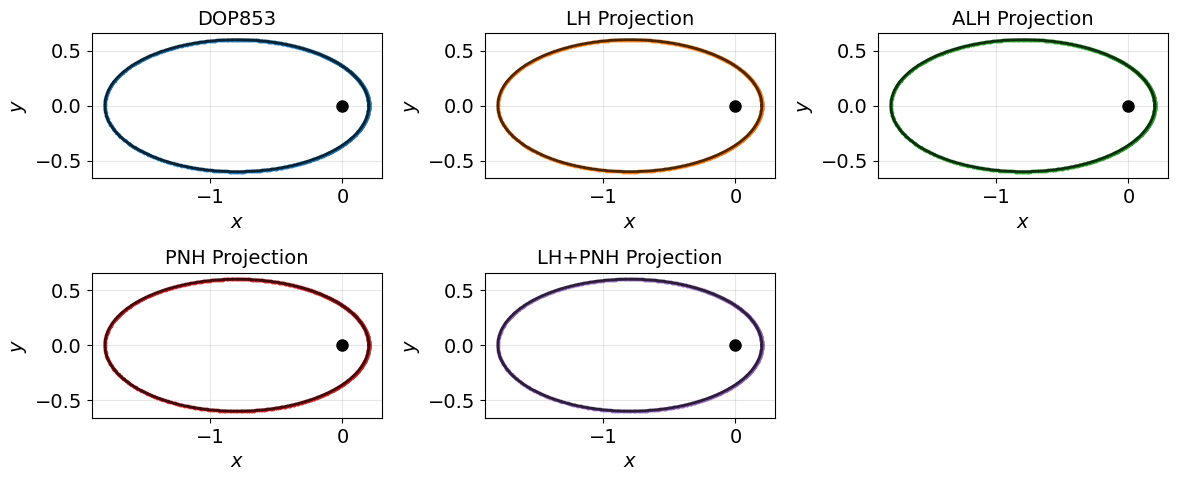

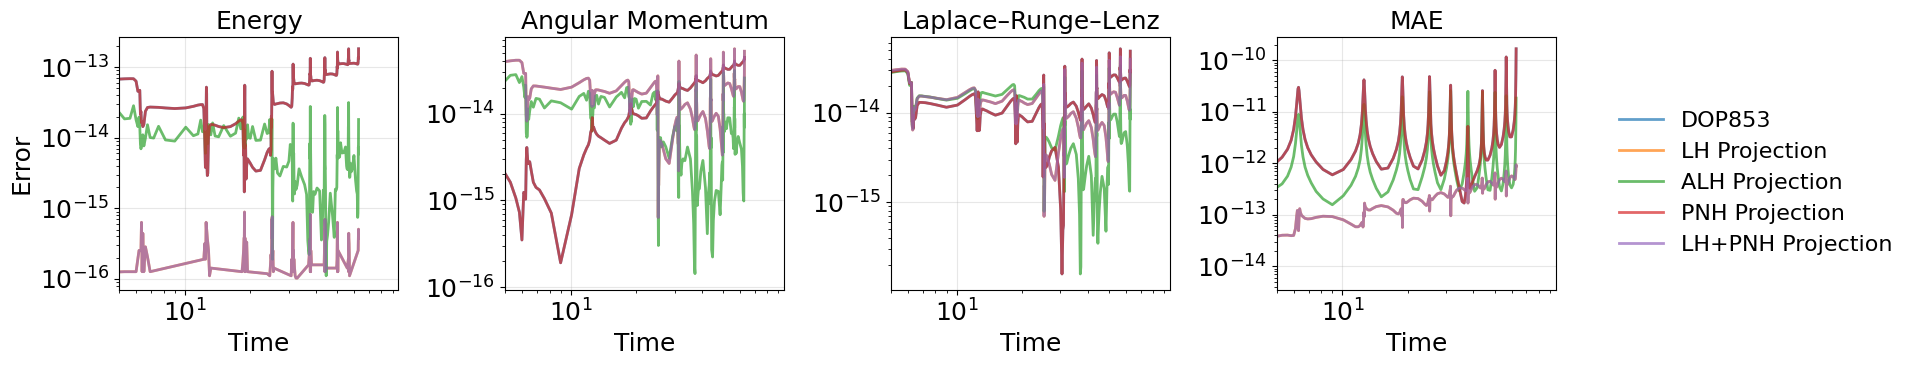

Running h=0.00464_tol=4.6e-11 (2/4)
Running DOP853...
Running LH Projection...
Running ALH Projection...
Running PNH Projection...
Running LH+PNH Projection...


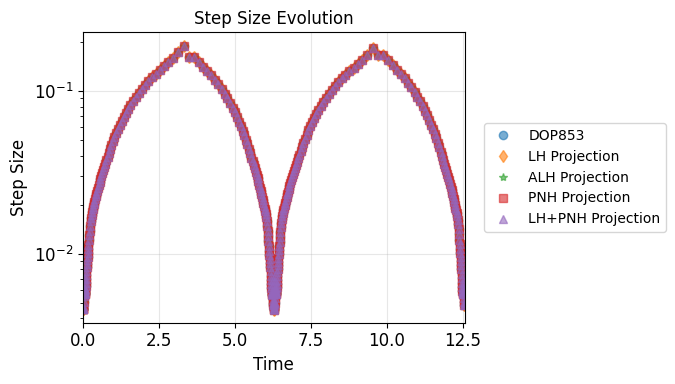

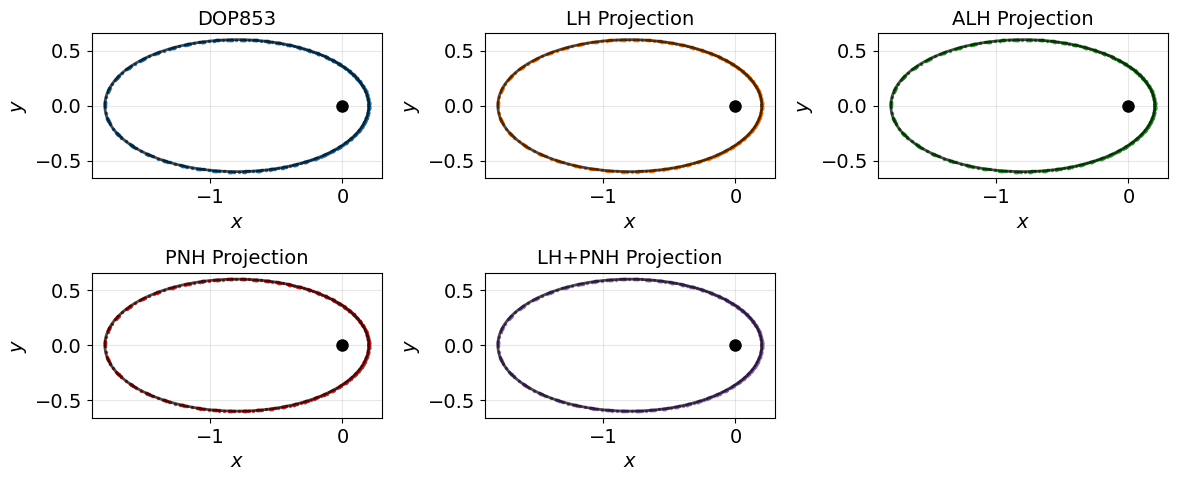

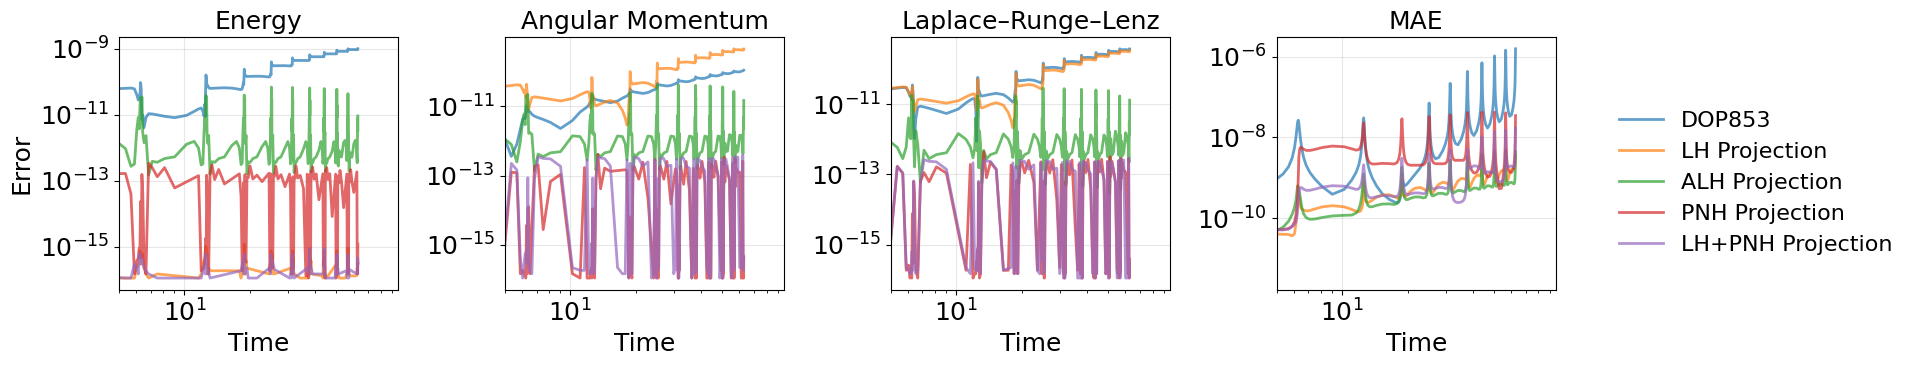

Running h=0.02154_tol=2.2e-07 (3/4)
Running DOP853...
Running LH Projection...
Running ALH Projection...
Running PNH Projection...
Running LH+PNH Projection...


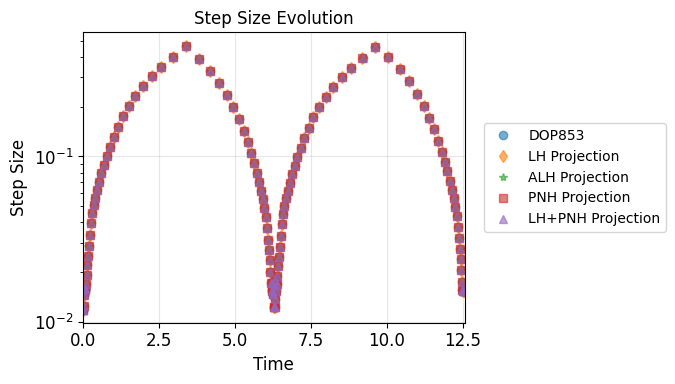

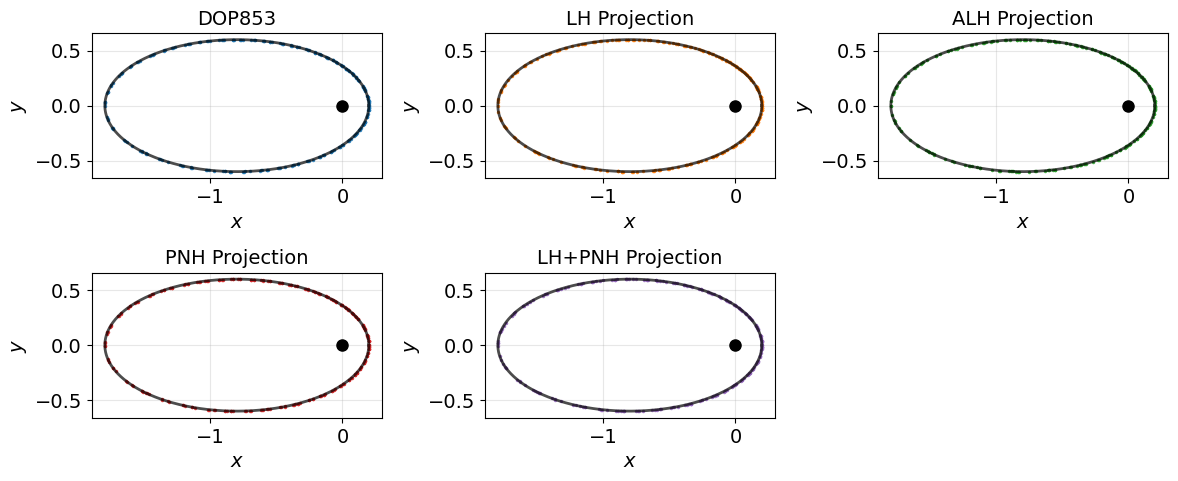

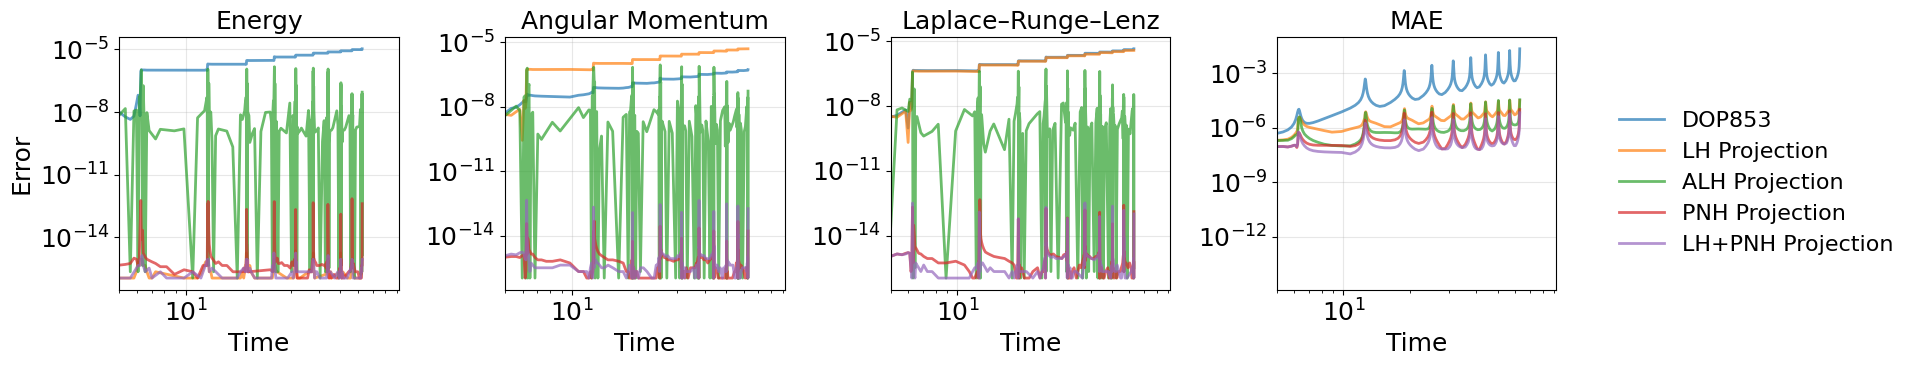

Running h=0.10000_tol=1.0e-03 (4/4)
Running DOP853...
Running LH Projection...
Running ALH Projection...
Running PNH Projection...
Running LH+PNH Projection...


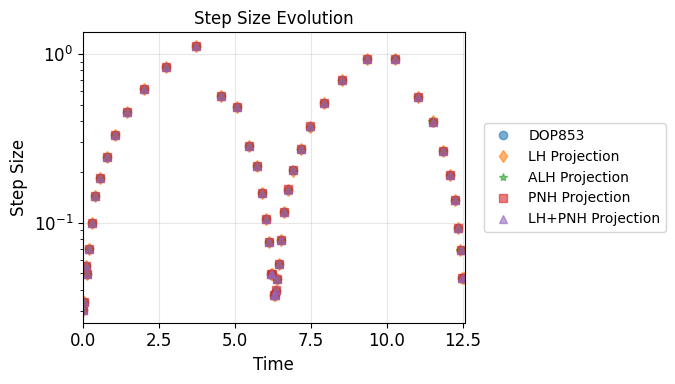

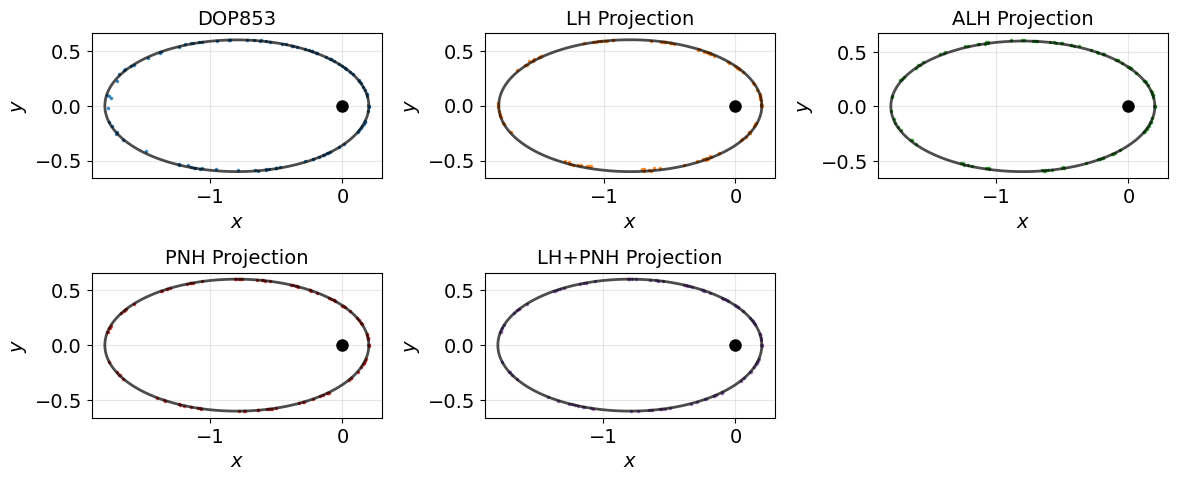

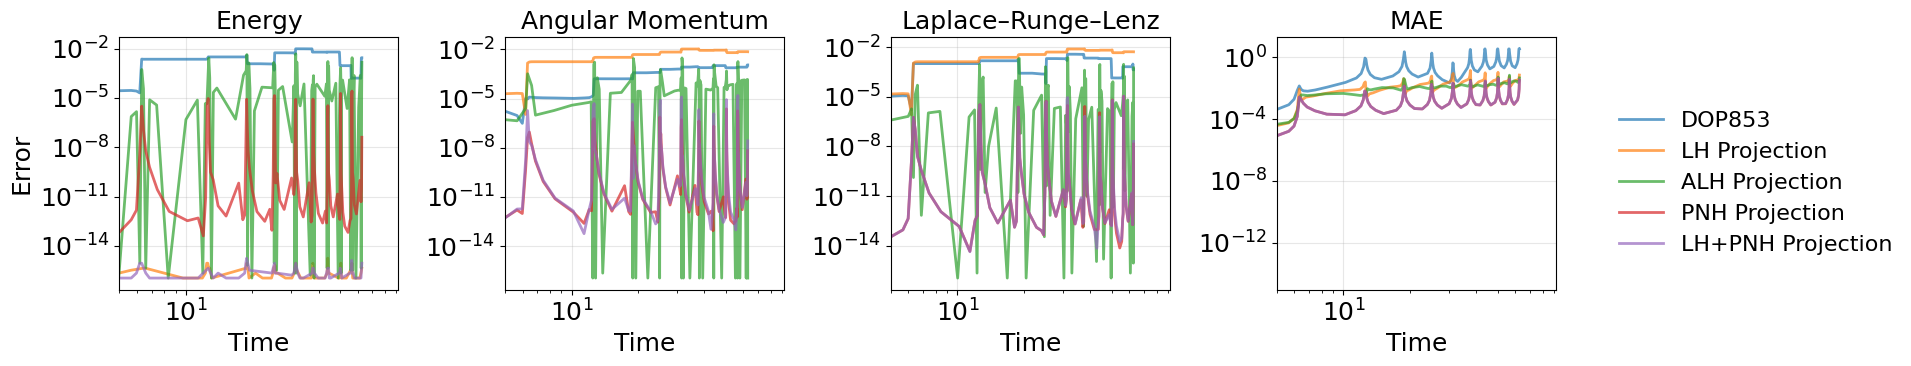


Parameter sweep complete. Total results: 20


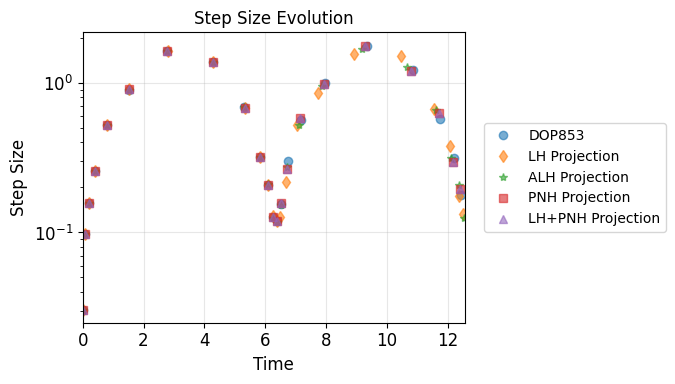

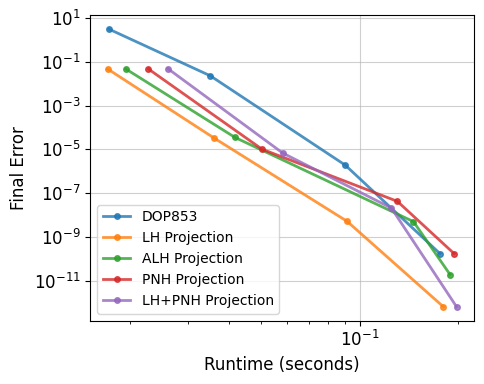

In [10]:
import pandas as pd
from keplerutils import plot_kepler_errors, plot_kepler_trajectories, plot_step_sizes, plot_error_performance_analysis

n_periods = 10
n_steps = 4
t_span = (0, n_periods*2*np.pi)

for eccentricity in [0.8]:
    SAVEFOLDER = f'../figs/kepler_comparison_e={eccentricity}_periods={n_periods}_fine/'
    os.makedirs(SAVEFOLDER, exist_ok=True)

    # Store all results
    all_results = []

    if eccentricity <= 0.8:
        eps_factor = 1
        h_range = np.logspace(-3, -1, n_steps)
        tol_range = np.logspace(-14, -3, n_steps)
    elif eccentricity == 0.9:
        eps_factor = 1/2
        h_range = np.logspace(-3, -1, n_steps)/2
        tol_range = np.logspace(-14, -3, n_steps)
    elif eccentricity > 0.95:
        eps_factor = 1/5
        h_range = np.logspace(-4, -2, n_steps)/2
        tol_range = np.logspace(-14, -3, n_steps)

    # Run parameter sweep
    for i, (h, tol) in enumerate(zip(h_range, tol_range)):

        param_str = f"h={h:.5f}_tol={tol:.1e}"
        print(f"Running {param_str} ({i+1}/{len(h_range)})")

        y0 = create_initial_state(eccentricity)
        solver_methods = create_solver_methods(y0)
        solutions = run_solvers(solver_methods, t_span, y0, h, tol, eps=h*eps_factor)

        t_ref = np.linspace(0, 2*np.pi, 1000)
        y_ref = kepler_exact_elliptic(y0, t_ref)

        fig1 = plot_kepler_trajectories(solutions, y_ref)
        fig2 = plot_kepler_errors(solutions, 
                                compute_energy,
                                compute_angular_momentum,
                                compute_third_invariant)
        fig3 = plot_step_sizes(solutions, n_periods=2)
        
        fig1.savefig(SAVEFOLDER + f"sols_{param_str}.png", dpi=150, bbox_inches='tight')
        fig2.savefig(SAVEFOLDER + f"errors_{param_str}.png", dpi=150, bbox_inches='tight')
        fig3.savefig(SAVEFOLDER + f"steps_{param_str}.png", dpi=150, bbox_inches='tight')

        # Extract metrics for each method
        for method_name, sol in solutions.items():
            final_error = sol.error[-1] if hasattr(sol, 'error') and len(sol.error) > 0 else np.nan
            all_results.append({
                'Method': method_name,
                'h': h,
                'tol': tol,
                'runtime': sol.runtime,
                'nfev': sol.nfev,
                'final_error': final_error,
                'success': True
            })

    # Convert to DataFrame for analysis
    df_results = pd.DataFrame(all_results)
    df_results.to_csv(os.path.join(SAVEFOLDER, 'kepler_parameter_sweep_results.csv'), index=False)
    print(f"\nParameter sweep complete. Total results: {len(df_results)}")

    fig = plot_error_performance_analysis(df_results, legend=True, plot_fevals=False)
    fig.savefig(SAVEFOLDER + 'kepler_error_vs_performance.png', dpi=300, bbox_inches='tight')
    plt.show()

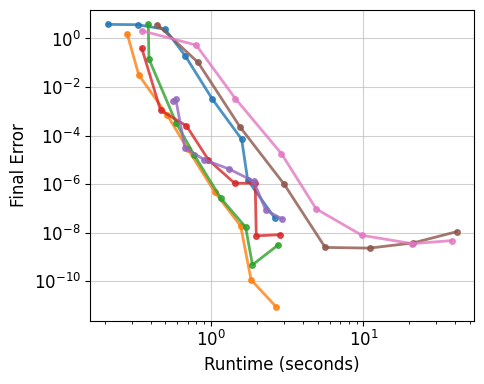

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from keplerutils import plot_error_performance_analysis
folders = [
    # '../figs/kepler_comparison_e=0.6_periods=100_fine/',
    # '../figs/kepler_comparison_e=0.8_periods=100_fine/',
    # '../figs/kepler_comparison_e=0.9_periods=100_fine/',
    # '../figs/kepler_comparison_e=0.99_periods=100_fine/',
]
for i, SAVEFOLDER in enumerate(folders):
    df_results = pd.read_csv(f'../figs/{SAVEFOLDER}/kepler_parameter_sweep_results.csv')
    fig = plot_error_performance_analysis(df_results, legend=False if i == 0 else False, plot_fevals=False)
    fig.savefig(SAVEFOLDER + 'kepler_error_vs_performance.png', dpi=300, bbox_inches='tight')
